In [8]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style("whitegrid", {'axes.grid': False})
import h5py
import tensorflow as tf
import scipy.io as io

import os
import numpy as np
from scipy import (signal, io)
import h5py
import tensorflow as tf
from keras.models import Sequential
from keras.layers import (Dense, Conv1D, GRU, LSTM, Recurrent, Bidirectional,
                          TimeDistributed, Dropout, Flatten, RepeatVector, Reshape)


from keras import backend as K
gpu_opts = tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4))
K.set_session(tf.Session(config=gpu_opts))
#K.set_image_data_format('channels_last')

In [165]:
#from autoencoder import load_data

X = load_data('data.mat', smooth = True)

In [164]:
def load_data(data_path, smooth = False, components = 15):
    f = io.matlab.loadmat(data_path)
    loop_data = f['Loopdata_mixed'][()]
    X = loop_data.reshape(loop_data.shape[0]*loop_data.shape[0],-1)
    X -= np.nanmean(X)
    X[np.where(np.isfinite(X)==0)] = 0
    X /= np.std(X)
    
    if smooth:
        # Sets the number of componets to save
        pca_model = decomposition.PCA(n_components=components)

        # Computes the PCA of the piezoelectric hysteresis loops
        PCA_data = pca_model.fit(X)

        # Does the inverse tranform - creates a low rank representation of the data
        X = pca_model.inverse_transform(pca_model.transform(X))
    
    X = np.atleast_3d(X)
    return X

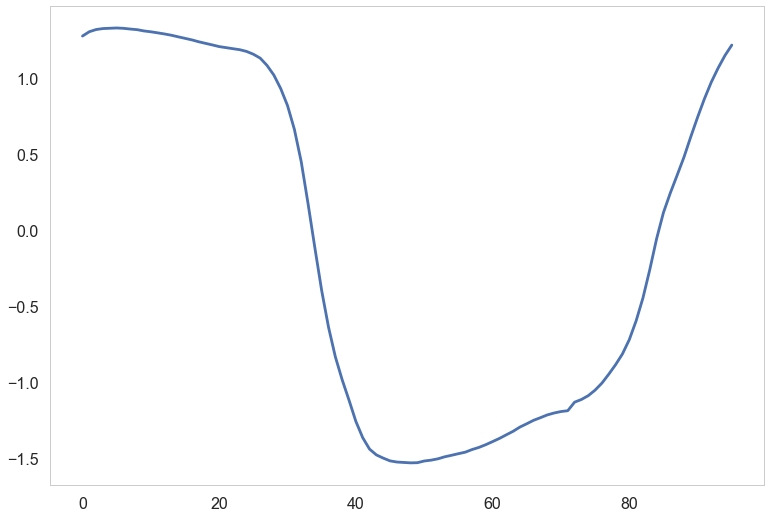

In [166]:
plt.plot(X[500].squeeze())

In [143]:
%%time
import keras

model = keras.models.load_model('log/lstm064_x2_emb008_5m04_drop0_batch64/weights.h5')

encode_model = keras.models.Model(inputs=model.input,
                                  outputs=[l for l in model.layers
                                           if isinstance(l, keras.layers.core.Dense)][0].output)
#inds = np.arange(20, X.shape[0], 40)
encoding = encode_model.predict(X)

CPU times: user 2min 11s, sys: 18.1 s, total: 2min 29s
Wall time: 2min 53s


In [61]:
encode_model.get_layer

<bound method Container.get_layer of <keras.engine.training.Model object at 0x13e648208>>

In [12]:
%%time
from sklearn.decomposition import PCA

pca_model = PCA(8)
pca_model.fit(X.squeeze())

CPU times: user 152 ms, sys: 108 ms, total: 260 ms
Wall time: 478 ms


In [167]:
import keras

model = keras.models.load_model('log/lstm128_x2_emb008_5m04_drop0_batch128/weights.h5')

/Users/joshuaagar/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/joshuaagar/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


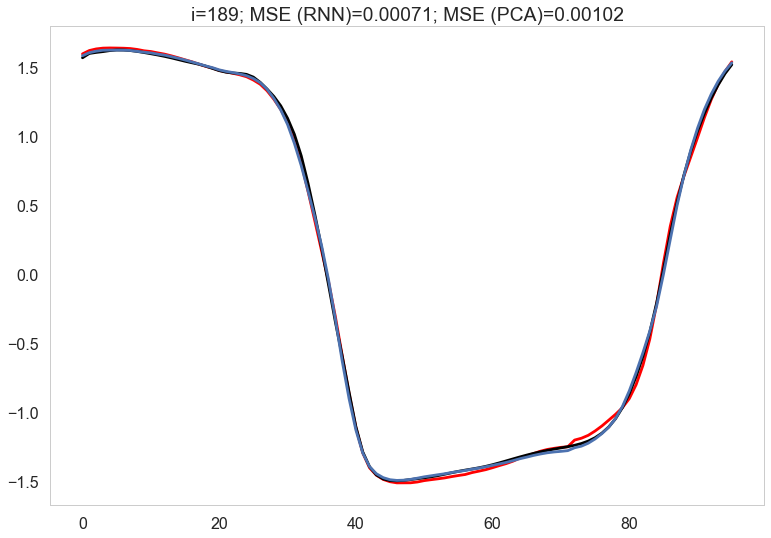

In [178]:
i = np.random.randint(0, X.shape[0])

plt.plot(X[i],'r')
plt.plot(model.predict(X[[i]])[0],'k')
plt.plot(pca_model.inverse_transform(pca_model.transform(X[[i]].squeeze())[0]))
mse_rnn = np.mean((X[i] - model.predict(X[[i]])[0]) ** 2)
mse_pca = np.mean((X[i].squeeze() - pca_model.inverse_transform(pca_model.transform(X[[i]].squeeze())[0])) ** 2)
#plt.plot(X[i] - model.predict(X[[i]])[0])
plt.title(f"i={i}; MSE (RNN)={mse_rnn:1.5f}; MSE (PCA)={mse_pca:1.5f}");

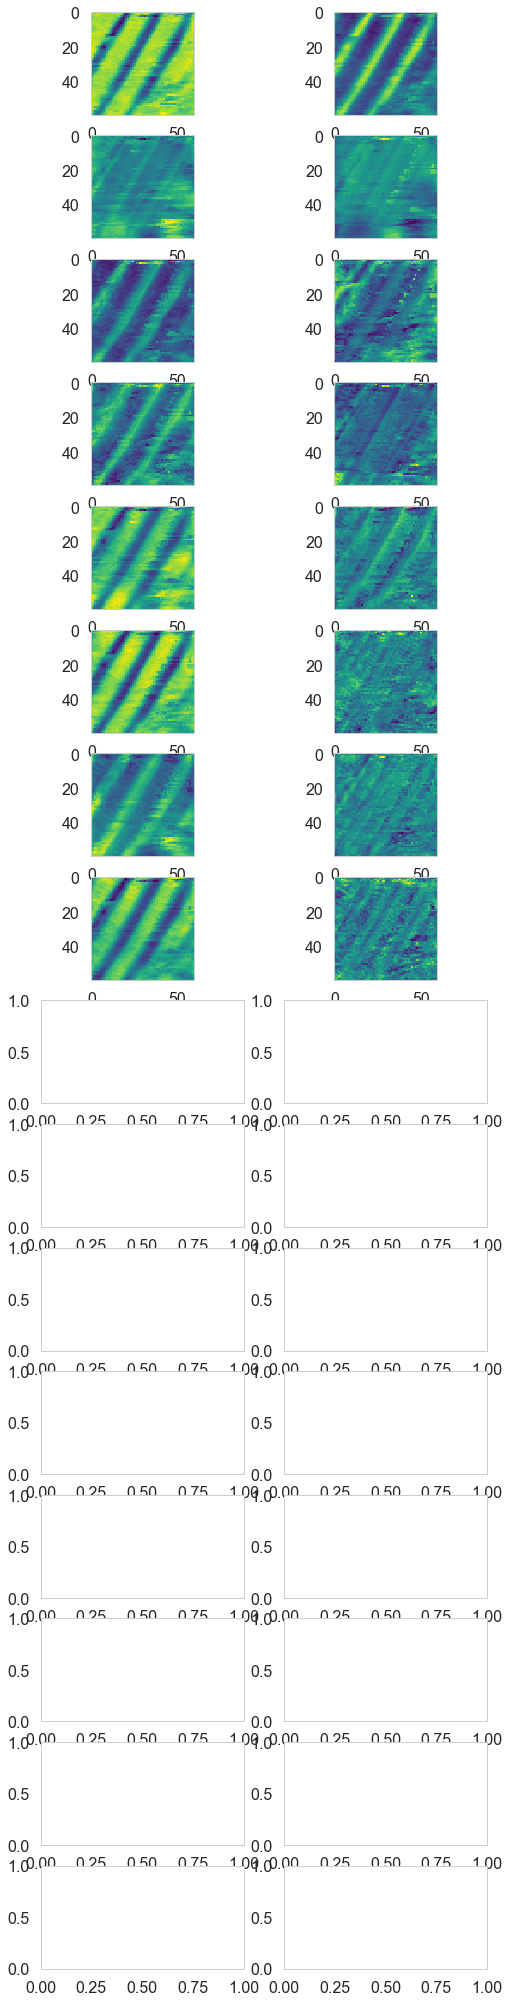

In [174]:
loadings = pca_model.transform(X.squeeze())
fig, ax = plt.subplots(16, 2, figsize=(8, 36))
for j in range(encoding.shape[1]):
    ax[j, 0].imshow(encoding[:, j].reshape((60, 60)), cmap='viridis')#, vmin=encoding.min(), vmax=encoding.max())
    ax[j, 1].imshow(loadings[:, j].reshape((60, 60)), cmap='viridis')#, vmin=encoding.min(), vmax=encoding.max())

In [82]:
from sklearn import (decomposition, preprocessing, cluster,
                     preprocessing, cluster, metrics)

In [84]:
# Scales the data for clustering
scaled_data_mixed = preprocessing.StandardScaler().fit_transform(loadings)

# Kmeans clustering of the data into c and a domains
cluster_ca_mixed = cluster.KMeans(n_clusters=2).fit_predict(scaled_data_mixed)

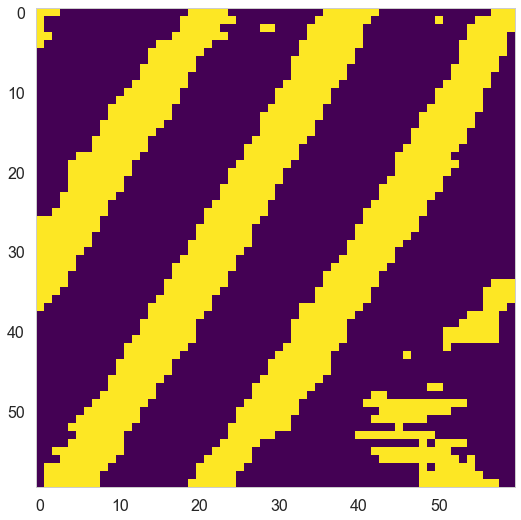

In [86]:
plt.imshow(cluster_ca_mixed.reshape(60,60),cmap='viridis')

In [93]:
# Kmeans clustering of a domains
a_map_mixed = np.zeros(3600)
a_cluster = cluster.KMeans(n_clusters=4).fit_predict(scaled_data_mixed[cluster_ca_mixed==1])
a_map_mixed[cluster_ca_mixed==1]=a_cluster+1

# Kmeans clustering of c domains
c_map_mixed = np.zeros(3600)
c_cluster = cluster.KMeans(n_clusters=5).fit_predict(scaled_data_mixed[cluster_ca_mixed==0])
c_map_mixed[cluster_ca_mixed==0]=c_cluster+5

# Enumerates the k-means clustering map for ploting
combined_map_mixed = a_map_mixed + c_map_mixed

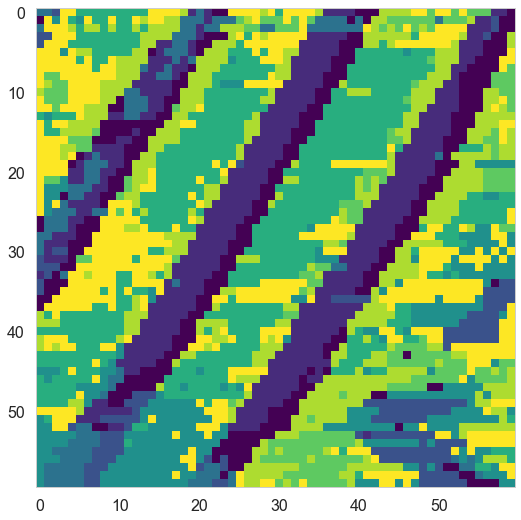

In [94]:
plt.imshow(combined_map_mixed.reshape(60,60),cmap='viridis')

In [82]:
from sklearn import (decomposition, preprocessing, cluster,
                     preprocessing, cluster, metrics)

In [99]:
# Scales the data for clustering
scaled_data_mixed = encoding#preprocessing.StandardScaler().fit_transform(encoding)

# Kmeans clustering of the data into c and a domains
cluster_ca_mixed = cluster.KMeans(n_clusters=2).fit_predict(scaled_data_mixed)

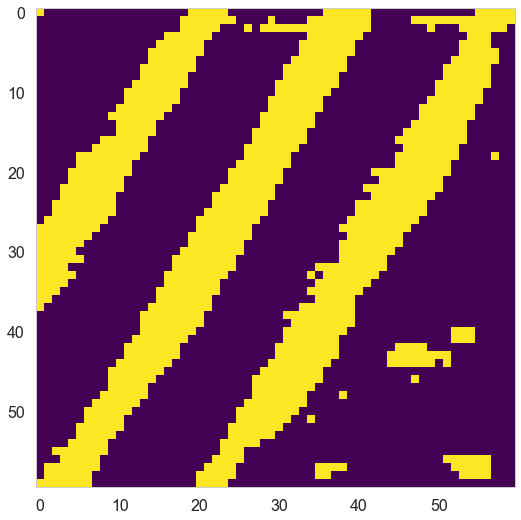

In [100]:
plt.imshow(cluster_ca_mixed.reshape(60,60),cmap='viridis')

In [101]:
# Kmeans clustering of a domains
a_map_mixed = np.zeros(3600)
a_cluster = cluster.KMeans(n_clusters=4).fit_predict(scaled_data_mixed[cluster_ca_mixed==1])
a_map_mixed[cluster_ca_mixed==1]=a_cluster+1

# Kmeans clustering of c domains
c_map_mixed = np.zeros(3600)
c_cluster = cluster.KMeans(n_clusters=5).fit_predict(scaled_data_mixed[cluster_ca_mixed==0])
c_map_mixed[cluster_ca_mixed==0]=c_cluster+5

# Enumerates the k-means clustering map for ploting
combined_map_mixed = a_map_mixed + c_map_mixed

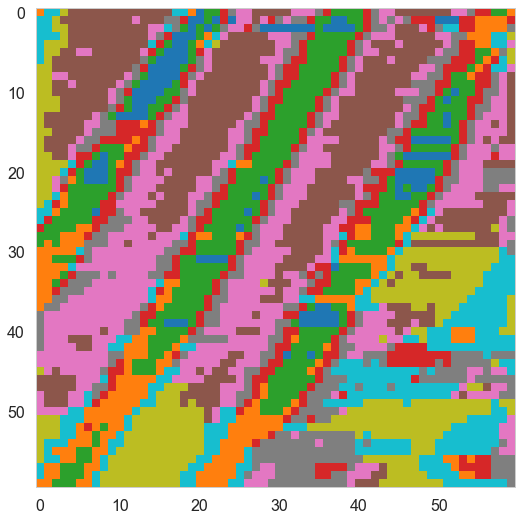

In [103]:
plt.imshow(combined_map_mixed.reshape(60,60),cmap='tab10')